In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as sps
import sklearn
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, FunctionTransformer, Binarizer, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


# Small Businesses and Loans

The purpose of this project is to determine which variables affect whether a loan is paid off or not, and how much the variables affect the loan. 

Relevant literature: https://www.tandfonline.com/doi/full/10.1080/10691898.2018.1434342

I will be using a majority class classifier, Logistic Regression, Lasso Regression, and Random Forest models to see which one can best predict which businesses can successfully pay off a loan using several variables.

- MIS_Status - PIF means paid in full. CHGOFF means charged off or not paid in full. This variable will be quantified in such a way that PIF will be 1 and CHGOFF will be 0.

- Recession - This variable will be 1 if a business applied for a loan during the 2008 recession. Zero otherwise.

- estateBacked - This variable is 1 if a loan is backed by estate. All loans with greater than 240 months in its term are backed by estate. 

- PercentDisbursed - portion of the loan that is guaranteed by SBA. This variable was described as important and relevant in the literature.

- Gross Disbursement - gross amount of money that is loaned out. Relevant to how big a business is. Small businesses don't get as much loan money as big businesses.

- NewExist - New or existing businesses. 1 if the business is existing. 2 if the business is new. A business being new is defined as being 2 or less years old.

I will be using regular Python code for the majority class classifier, logistic regression, and lasso regression. The random forest will be executed using pipelines.

## Data Prep and Exploration

In [2]:
file = pd.read_csv('SBAnational.csv')
rng = np.random.RandomState(20201024)
file.columns

C:\Users\zacki\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

In [3]:
file.shape

(899164, 27)

There are 899164 rows and 27 columns.

In [4]:
#Replace paid in full to 1 and not paid in full to 0.
file['MIS_Status']=file['MIS_Status'].replace('P I F',1)
file['MIS_Status']=file['MIS_Status'].replace('CHGOFF',0)

In [5]:
#Convert dates to datetime
file['DisbursementDate'] = pd.to_datetime(file['DisbursementDate'])
file['ApprovalDate'] = pd.to_datetime(file['ApprovalDate'])

In [6]:
file.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

In [7]:
#Converting currency to floats
file[file.columns[21]] = file[file.columns[21]].replace('[\$,]', '', regex=True).astype(float)
file[file.columns[22]] = file[file.columns[22]].replace('[\$,]', '', regex=True).astype(float)
file[file.columns[24]] = file[file.columns[24]].replace('[\$,]', '', regex=True).astype(float)
file[file.columns[25]] = file[file.columns[25]].replace('[\$,]', '', regex=True).astype(float)
file[file.columns[26]] = file[file.columns[26]].replace('[\$,]', '', regex=True).astype(float)

In [8]:
#Drop some na in specific columns
file = file.dropna(subset=['NewExist','MIS_Status','DisbursementDate'])

## Describing Variables

### MIS_Status

In [9]:
#Majority class classifier - guess the class with most obs in it for every classification
file['MIS_Status'].value_counts()/file['MIS_Status'].count()

1.0    0.82431
0.0    0.17569
Name: MIS_Status, dtype: float64

Majority class classifier - 82 percent of the loan observations have been paid off.

The accuracy is 0.824. The precision is also 0.824. The recall is 1. The recall is 1 because there are no false negatives since every classification was a 1.

In [10]:
#Distribution of outcome variable
file['MIS_Status'].value_counts()

1.0    737640
0.0    157218
Name: MIS_Status, dtype: int64

MIS_Status is a binary variable that describes whether or not a loan was paid in full. This variable is one if a loan is paid in full and a zero if the loan is not paid in full. This variable is the dependant variable.

The distribution of this variable is that there are more observations where the loan is paid in full than observations where the loan is not paid in full. The dataset consists of around 82% paid in full observations and 18% not paid in full observations.

### Recession

In [11]:
#See if disbursement date is within 2008 Recession. 1 if it is, 0 otherwise
file['RecessBin'] = np.where((file['DisbursementDate']<'2009-06-30') & (file['DisbursementDate']> '2007-12-01'),1,0)
file['RecessBin'] = file['RecessBin'].astype('float64')

In [12]:
#Number of observations in each category
file['RecessBin'].value_counts()

0.0    844543
1.0     50315
Name: RecessBin, dtype: int64

In [13]:
#Percent of observations in each category
file['RecessBin'].value_counts()/file['RecessBin'].count()

0.0    0.943773
1.0    0.056227
Name: RecessBin, dtype: float64

RecessBin is a dummy variable I created that is 1 if the loan was active during the great recession and 0 otherwise. It makes sense that more businesses would lose money during the great recession, so including it in the analysis should help the model explain risk. MIS_Status's relationship to RecessBin is this: when RecessBin is 1, MIS_Status has a lower count. When RecessBin is 0, MIS_Status has a higher count.

Judging from the percentage of observations in the 1 category, most observations were not recorded in the 2008 recession.

### Backed by Estate

In [14]:
#A business is estate backed if its term is greater than 240 months. estateBacked =1 if backed by estate
file['estateBacked'] = file['Term']>=240
file['estateBacked'] = file['estateBacked'].astype('float64')

In [15]:
#Observation count of whether a loan was backed by estate
file['estateBacked'].value_counts()

0.0    742805
1.0    152053
Name: estateBacked, dtype: int64

In [16]:
#Percentage of estate backed loans
file['estateBacked'].value_counts()/file['estateBacked'].count()

0.0    0.830081
1.0    0.169919
Name: estateBacked, dtype: float64

EstateBacked is another dummy variable I created that is 1 if the loan is backed with estate and 0 if the loan isn't backed by estate. A loan that is backed by estate has greater than 240 months in its term. A loan that is backed by estate is more likely to be paid in full since it has property that can be taken if the loan is not fully paid. 

According to the value counts of this variable, most loans were not estate backed. 

### Percent Disbursed

In [17]:
#GrApprv - Gross Amount of Loan Approved by Bank
#SBA_Appv - SBA’s Guaranteed Amount of Approved Loan
file['percDisbursed'] = file['SBA_Appv']/file['GrAppv']

In [18]:
file['percDisbursed'].describe()

count    894858.000000
mean          0.710011
std           0.173649
min           0.028140
25%           0.500000
50%           0.750000
75%           0.850000
max           1.000000
Name: percDisbursed, dtype: float64

<AxesSubplot:xlabel='percDisbursed'>

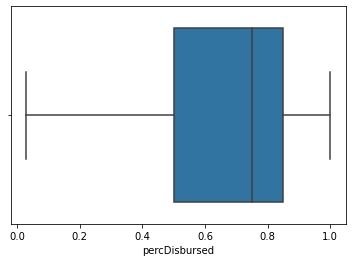

In [19]:
sns.boxplot(x=file['percDisbursed'])

percDisbursed is the portion of the loan that is guaranteed by SBA. I chose to include this variable because it was included in the relevant literature and because according to the literature, paid in full loans usually have a higher SBA guaranteed percentage than charged off loans. This variable's relationship to MIS_Status is this: loans that are paid in full have a higher SBA guaranteed percentage.

The distribution of percDisbursed is left skewed with a mean of 0.710. The 25th percentile is 0.5, the 50th percentile is 0.75, and the 75th percentile is 0.85. 

### Gross Disbursement

In [20]:
file['DisbursementGross'].describe()

count    8.948580e+05
mean     2.017989e+05
std      2.878199e+05
min      4.000000e+03
25%      4.265300e+04
50%      1.000000e+05
75%      2.395000e+05
max      1.144632e+07
Name: DisbursementGross, dtype: float64

<AxesSubplot:xlabel='DisbursementGross', ylabel='Count'>

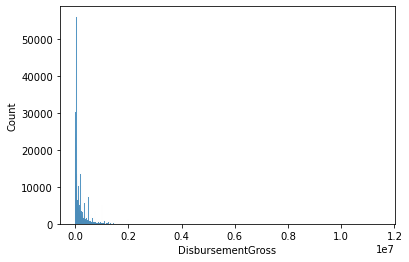

In [21]:
sns.histplot(x=file['DisbursementGross'])

DisbursementGross is the gross amount of money that is loaned out. I chose to include this variable because larger sized loans usually go to established businesses that are looking to expand. These established businesses would have an easier time paying off loans since they are established and probably have a steady stream of income. DisbursementGross's relationship to MIS_Status is this: loans with a higher DisbursementGross usually have a higher likelihood of being paid in full. Loans with a lower DisbursementGross are more likely to be coming from a less established business and have less likelihood of being paid in full than more established businesses.

The distribution of this variable is right skewed, as seen in the histplot. The mean is 201,000 dollars. The median is 100,000 dollars. The 25th percentile is 42,000 dollars. The 75th percentile is 240,000 dollars.

### New or Existing Businesses

In [22]:
#Count of businesses that are new or existing
file['NewExist'].value_counts()

1.0    641861
2.0    251970
0.0      1027
Name: NewExist, dtype: int64

In [23]:
# Percentage of businesses that are new or existing.
file['NewExist'].value_counts()/file['NewExist'].count()

1.0    0.717277
2.0    0.281575
0.0    0.001148
Name: NewExist, dtype: float64

NewExist is a dummy variable that is 1 if the business the loan is going to is existing and 2 if the business the loan is going to is new. A new business is defined as being less than or equal to 2 years old. I chose this variable because established businesses would have a better chance of paying off their loan in full because those business has a track record of success and are trying to expand their business. Newer businesses would have a lower chance of paying off their loan in full because they are not established and might encounter obstacles they may not have anticipated. According to the literature, there is a relatively negligible difference for the default rates between new and existing businesses. The default rate for new businesses is 18.98% and the default rate for existing businesses is 17.36%. This is also the relationship to the MIS_Status variable.

This variable had some zeroes in it that were not included in the documentation. I left them in because there weren't enough to make a difference and I had already dropped NA values in this column so these zeroes were probably not NAs.

The distribution of this variable is that most of the observations are 1 for this variable, so most of the loans are going towards existing businesses. There is still a significant chunk of loans that are going to new businesses. Around 71% of loans are going towards existing businesses.

### Training and Testing sets
Making training and testing sets from the dataset. Testing consists of 25% of the observations.

In [24]:
#Make training and testing masks
test = file.sample(frac=0.25, random_state=rng)
train_mask = pd.Series(True, index=file.index)
train_mask[test.index] = False
train = file[train_mask].copy()

## Initial Logistic Model

In [25]:
#Variables to include: RecessBin, estateBacked, percDisbursed, DisbursementGross, NewExist
mod = smf.glm('MIS_Status ~ RecessBin + estateBacked + percDisbursed + DisbursementGross + NewExist', train,
              family=sm.families.Binomial())
lg_res = mod.fit()
lg_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             MIS_Status   No. Observations:               671144
Model:                            GLM   Df Residuals:                   671138
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.8865e+05
Date:                Tue, 21 Dec 2021   Deviance:                   5.7729e+05
Time:                        17:23:57   Pearson chi2:                 6.62e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3447      0.016     22.002      0.000       0.314       0.375
RecessBin            -0.6927      0.012    -58.150      0.000      -0.716      -0.669
estateBacked          2.3231      0.024     95.305      0.000       2.275       2.371
percDisbursed         1.6511      0.021     79.030      0.000       1.610       1.692
DisbursementGross  3.279e-07   1.67e-08     19.644      0.000    2.95e-07    3.61e-07
NewExist             -0.0787      0.007    -10.785      0.000      -0.093      -0.064
=====================================================================================
"""

C:\Users\zacki\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='LRscore', ylabel='Density'>

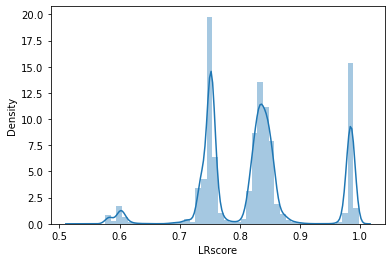

In [26]:
#Using train data
train['LRscore'] = lg_res.predict(train)
sns.distplot(train['LRscore'])

C:\Users\zacki\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='LRscore', ylabel='Density'>

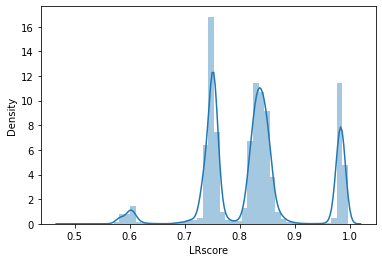

In [27]:
#Using testing data
test['LRscore'] = lg_res.predict(test)
sns.distplot(test['LRscore'])

In [28]:
#Testing Accuracy
test['LRscore'] = lg_res.predict(test)
test['LRdecision'] = test['LRscore'] > 0.5
(test['MIS_Status'] == test['LRdecision']).mean()

0.8245036072843005

The accuracy is 0.8244, 0.001 higher than the majority class classifier accuracy.

In [29]:
#Decision matrix of this model
out_counts = test.groupby(['LRdecision','MIS_Status'])['LRscore'].count()
out_counts

LRdecision  MIS_Status
False       1.0                1
True        0.0            39260
            1.0           184453
Name: LRscore, dtype: int64

This model guessed false once, and got it wrong. The rest of the time it guessed True and was the exact same as the majority class classifier.

## Lasso Regression

In [30]:
#Columns to be included
feat_cols = ['RecessBin', 'estateBacked', 'percDisbursed', 'DisbursementGross', 'NewExist']

#Dependent var
out_col = 'MIS_Status'

#Training data
train_x = train[feat_cols]
train_y = train[out_col]

#Testing data
test_x = test[feat_cols]
test_y = test[out_col]

In [31]:
#Lasso regression
lg_modLasso = LogisticRegressionCV(penalty='l1',solver = 'liblinear',max_iter = 500).fit(train_x,train_y)

In [32]:
#Accuracy of training
train_Lasso = lg_modLasso.predict(train_x)
np.mean(train_Lasso == train_y)

0.8242433814501806

In [34]:
test['Lassoscore'] = lg_modLasso.predict(test_x)
test['Lassodecision'] = test['Lassoscore']

In [36]:
#Accuracy of training
train_Lasso = lg_modLasso.predict(train_x)
np.mean(train_Lasso == train_y)

0.8242433814501806

In [35]:
#Accuracy of test 
(test['MIS_Status'] == test['Lassodecision']).mean()

0.8245080772772378

In [37]:
#Decision matrix
out_counts = test.groupby(['Lassodecision','MIS_Status'])['Lassoscore'].count()
out_counts

Lassodecision  MIS_Status
1.0            0.0            39260
               1.0           184454
Name: Lassoscore, dtype: int64

The majority class classifier accuracy was 0.82431. This lasso regression is the exact same as the majority class classifier, according to the decision matrix. 

## Random Forest

In [51]:
#Create training and testing sets
train_x = train.drop(columns=['ChgOffDate', 'ChgOffPrinGr', 'MIS_Status','BalanceGross'])
test_x = test.drop(columns=['ChgOffDate', 'ChgOffPrinGr', 'MIS_Status', 'BalanceGross'])

train_y = train['MIS_Status']
test_y = test['MIS_Status']

In [39]:
# Creates a new column to X dataframe. If an observation is 2, the dataframe's value will be 1.
def f_is_new(X, *args):
    res = X['NewExist'] == 2
    return res.to_frame('IsNew')

In [41]:
#Percent Disbursed in a function for pipeline
def f_portion(X, *args):
    res = X['SBA_Appv'] / X['GrAppv']
    return res.to_frame('Portion')

In [43]:
#A function of RecessBin for the pipeline
def f_is_recession(X, *args):
    start = pd.to_datetime('2007-12-01')
    end = pd.to_datetime('2009-06-30')
    db = X['DisbursementDate'] < start
    due = X['DisbursementDate'].copy()
    term = X['Term']
    for t in term.unique():
        tdo = pd.DateOffset(months=t)
        due[term == t] += tdo
    res = (due >= start) & (due <= end)
    return res.to_frame('Recession')

In [46]:
#Pipeline for preparing data
rf_prep = ColumnTransformer([
    ('IsNew', FunctionTransformer(f_is_new), ['NewExist']),
    ('RealEstate', Binarizer(threshold=240), ['Term']),
    ('Portion', FunctionTransformer(f_portion), ['GrAppv', 'SBA_Appv']),
    ('Recession', FunctionTransformer(f_is_recession), ['DisbursementDate', 'Term']),
    ('Numerics', SimpleImputer(), make_column_selector(dtype_include=np.number))
])

In [47]:
#Pipeline for preparing then using random forest classifier.
rf_pipe = Pipeline([
    ('prep', rf_prep),
    ('classify', RandomForestClassifier(max_depth=10))
])

In [53]:
#Fitting the model
rf_pipe.fit(train_x, train_y)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('IsNew',
                                                  FunctionTransformer(func=<function f_is_new at 0x0000026D1224B1F0>),
                                                  ['NewExist']),
                                                 ('RealEstate',
                                                  Binarizer(threshold=240),
                                                  ['Term']),
                                                 ('Portion',
                                                  FunctionTransformer(func=<function f_portion at 0x0000026D11D96280>),
                                                  ['GrAppv', 'SBA_Appv']),
                                                 ('Recession',
                                                  FunctionTransformer(func=<function f_is_recession at 0x0000026D11D96A60>),
                                                  ['DisbursementDate', 'Term']),
      

In [54]:
#Training accuracy
accuracy_score(train_y, rf_pipe.predict(train_x))

0.9228183519483151

In [56]:
#Testing accuracy
accuracy_score(test_y, rf_test_out)

0.9221684829737969

The testing accuracy of this random forest is 0.922. The testing accuracy of the majority class classifier is 0.82431. The random forest had 0.09769 greater of an accuracy than the majority class classifier. Pretty good since the logistic regression model just mirrored the majority class classifier.

## Results

Overall, the Random Forest performed the best. Other models mirrored the majority class classifier or only deviated for one observation. The random forest proved to be the correct tool for the job, with a testing accuracy of 0.92216. This kind of accuracy is good for a project that tries to see which models work the best for this problem. In the real world, this accuracy would be bad for trying to predict which businesses should be given loans. Real models for this kind of question would have more variables, more optimization, and more time and people working on it.